In [1]:
import pandas as pd 
import numpy as np
import math
from PIL import Image
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Dense, Flatten, Activation, Conv2D, MaxPool2D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model
import tensorflow as tf

In [2]:
train = pd.read_csv('MNIST_data/train.csv')
test = pd.read_csv('MNIST_data/test.csv')
label = train.pop('label')

In [3]:
print("train dimension:", train.shape)
print("test dimension:", test.shape)

train dimension: (42000, 784)
test dimension: (28000, 784)


## Preprocessing

In [4]:
#전처리 클래스 생성
class PreprocessData:
    def __init__(self, valid_size, random_state, scaling=False):
        self.valid_size = valid_size
        self.random_state = random_state
        self.scaling = scaling
    def load_datasets(self):
        (train_images, train_labels), (test_images,test_labels) = cifar10.load_data()
        
    def scaled_pixels(self,images,labels):
        if self.scaling: #scaling이 True일 경우
            images = np.array(images / 255.0, dtype=np.float32)
        else:
            images = np.array(images,dtype=np.float32)
        labels = np.array(labels, dtype=np.float32)
        return images, labels
    
    def transform_ohe(self,labels):
        ohe_labels = to_categorical(labels)
        return ohe_labels
    
    def split_train_valid(self,train_images, train_ohe_labels,train_labels): #훈련데이터에서 검증데이터 추출
        tr_images, val_images, tr_ohe_labels, val_ohe_labels,tr_labels,val_labels = train_test_split(train_images,
                                                                               train_ohe_labels,train_labels, test_size=self.valid_size,
                                                                               random_state = self.random_state)
        return tr_images, val_images, tr_ohe_labels, val_ohe_labels, tr_labels,val_labels
    def preprocess_data(self):
        train_images,train_labels,test_images = train, label, test
        
        train_images, train_labels = self.scaled_pixels(train_images,train_labels)
        
        
        train_ohe_labels = self.transform_ohe(train_labels)
        
        
        tr_images,  val_images, tr_ohe_labels, val_ohe_labels ,tr_labels,val_labels = self.split_train_valid(train_images,train_ohe_labels,train_labels)
        
        
        tr_images = tr_images.reshape(-1,28,28,1)
        val_images = val_images.reshape(-1,28,28,1)
        test_images = test_images.values.reshape(-1,28,28,1)
        print('Train:' ,tr_images.shape,tr_labels.shape, tr_ohe_labels.shape)
        print('Valid:', val_images.shape, val_ohe_labels.shape)
        print('Test:' ,test_images.shape)
        print
        return tr_images, tr_ohe_labels, val_images, val_ohe_labels, test_images,tr_labels,val_labels


In [5]:
tr_images, tr_ohe_labels, val_images, val_ohe_labels, test_images,tr_labels,val_labels  = PreprocessData(0.3,42,scaling=True).preprocess_data()

Train: (29400, 28, 28, 1) (29400,) (29400, 10)
Valid: (12600, 28, 28, 1) (12600, 10)
Test: (28000, 28, 28, 1)


## Modeling

In [53]:
early_stopping = EarlyStopping(monitor='val_acc', patience=1)
model.fit(x_train, to_categorical(Y_train), batch_size = 128, nb_epoch=100, verbose = 2, validation_split = .2)
yPred = model.predict_classes(x_valid,batch_size=32,verbose=1)
np.savetxt('mnist_output.csv', np.c_[range(1,len(yPred)+1),yPred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

In [7]:
#CNN Modeling 클래스 생성
class CnnModel:
    input_size = 32
    @classmethod
    def change_input_size(cls,input_size):
        CnnModel.input_size = input_size
    
    @staticmethod
    def create_model(verbose=True):
        size = CnnModel.input_size
        input_tensor = Input(shape=(size,size,1)) #왜 3차원인지 생각해보자   
        x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal', activation='relu')(
                    input_tensor)
        x = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)

        x = Conv2D(filters=64, kernel_size=3, padding='same',kernel_initializer='he_normal',activation='relu')(x)
        x = Conv2D(filters=64, kernel_size=3, padding='same',kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)

        x = Conv2D(filters=128, kernel_size=3, padding='valid', kernel_initializer='he_normal',activation='relu')(x)
        x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2)(x)

        x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Flatten()(x)
        x = Dropout(rate=0.4)(x)
        x = Dense(units=256, kernel_initializer='he_normal', activation='relu')(x)
        x = Dropout(rate=0.3)(x)
        x = Dense(units=64, kernel_initializer='he_normal', activation='relu')(x)
        output = Dense(units=10, activation='softmax')(x)

        model = Model(inputs=input_tensor, outputs=output)

        if verbose:
            model.summary()

        return model

In [12]:
CnnModel.change_input_size(input_size=28)
print(CnnModel().input_size)

28


In [13]:
model = CnnModel.create_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                       

In [25]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
history=model.fit(tr_images,tr_labels,epochs=3,validation_data=(val_images, val_labels),
                  batch_size=None)

Epoch 1/3
919/919 [==============================] - 229s 246ms/step - loss: 0.0512 - accuracy: 0.9861 - val_loss: 0.0399 - val_accuracy: 0.9896
Epoch 2/3
919/919 [==============================] - 210s 229ms/step - loss: 0.0429 - accuracy: 0.9871 - val_loss: 0.0434 - val_accuracy: 0.9887
Epoch 3/3
919/919 [==============================] - 229s 249ms/step - loss: 0.0362 - accuracy: 0.9902 - val_loss: 0.0512 - val_accuracy: 0.9872


In [27]:
predictions = np.argmax(model.predict(test_images), axis=1)

875/875 [==============================] - 50s 57ms/step


394/394 - 18s - loss: 0.0512 - accuracy: 0.9872 - 18s/epoch - 45ms/step


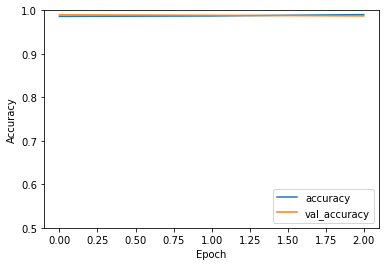

In [26]:
#Access Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_images,  val_labels, verbose=2)

In [28]:
submission = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predictions})
submission.to_csv('submission_modelB_tuning.csv', index=False)

In [141]:
#학습데이터 보충을 위한 데이터 추가 생성
#학습 과정 중 완전히 일치하는 동일 데이터를 못보게 하는 원리
datagen  = ImageDataGenerator(rotation_range=10,horizontal_flip=True,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
datagen.fit(train)

In [142]:
datagen.fit_generate(train1)

AttributeError: 'ImageDataGenerator' object has no attribute 'fit_generate'